In [4]:
from coglib import coglib
api = coglib.DataFeedAdaptor();
login=api.login("Bhanu.API","Reset@123");
print(login.status)
if login.status==True:
    QReal_GDP=api.get_econ_timeseries("14495",False)        
    for hist in QReal_GDP.response:
        hist.name
        print(hist.name)
        #print(hist.series)

True
Constant Prices-GDP at Market Price - Constant - Quarterly


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import pandas as pd

# Assuming successful API login
login = api.login("Bhanu.API", "Reset@123")
print(login.status)

if login.status:
    QReal_GDP = api.get_econ_timeseries("14495", False)
    econ_data = QReal_GDP.response[0]  # Assuming the response has necessary data

    # Create DataFrame
    QGDPplotdata = pd.DataFrame(econ_data.series)

    # Select relevant columns
    QGDPplotdata = QGDPplotdata[['date', 'value']]

    # Convert 'date' column to datetime and set it as index
    QGDPplotdata['date'] = pd.to_datetime(QGDPplotdata['date'])
    QGDPplotdata = QGDPplotdata.set_index('date')

    # Ensure 'value' is numeric
    QGDPplotdata['value'] = pd.to_numeric(QGDPplotdata['value'])

    # Filter data for the last 4 years
    cutoff_date = pd.to_datetime('2014-06-30')
    QGDPplotdata = QGDPplotdata[QGDPplotdata.index >= cutoff_date]



True


In [7]:
# Sort the filtered DataFrame by date
QGDPplotdata = QGDPplotdata.sort_index()

In [8]:
#print(QGDPplotdata)

In [9]:
# Correctly assign quarters based on the original format
def assign_quarters(data):
    quarter_mapper = {3: 'Q4', 6: 'Q1', 9: 'Q2', 12: 'Q3'}
    data['quarter'] = data.index.month.map(quarter_mapper)
    return data

# Add 'year' and 'quarter' columns
QGDPplotdata = assign_quarters(QGDPplotdata)
QGDPplotdata['year'] = QGDPplotdata.index.year

# Generate x-axis labels as 'YYYY QX'
QGDPplotdata['label'] = QGDPplotdata.apply(lambda x: f"{x['year']} {x['quarter']}", axis=1)

In [10]:
#print(QGDPplotdata)

In [11]:
# Define function to get fiscal year and quarter
def get_fiscal_year_quarter(date):
    if date.month >= 4 and date.month <= 6:
        fiscal_year = date.year
        quarter = 'Q1'
    elif date.month >= 7 and date.month <= 9:
        fiscal_year = date.year
        quarter = 'Q2'
    elif date.month >= 10 and date.month <= 12:
        fiscal_year = date.year
        quarter = 'Q3'
    else:  # January to March
        fiscal_year = date.year + 1
        quarter = 'Q4'
    return f"FY{fiscal_year} {quarter}"

 # Define function to get fiscal year label
def get_fiscal_year_label(date):
    if date.month >= 4:  # April to March
        fiscal_year = date.year + 1
    else:
        fiscal_year = date.year
    return f"FY{fiscal_year - 2000}"

# Add fiscal year and quarter columns
QGDPplotdata['fiscal_year_quarter'] = QGDPplotdata.index.map(get_fiscal_year_quarter)
QGDPplotdata['yearlabel'] = QGDPplotdata.index.map(get_fiscal_year_label)
QGDPplotdata['Displaylabel'] = QGDPplotdata.index.map(get_fiscal_year_label)+ QGDPplotdata.quarter

#print(QGDPplotdata)


In [12]:
# Calculate YoY Growth Rate
QGDPplotdata['QGDPgrowth'] = QGDPplotdata['value'].pct_change(periods=4) * 100
QGDPplotdata['QGDPgrowth'] = QGDPplotdata['QGDPgrowth'].round(1)
#print(QGDPplotdata)
# Calculate the moving average
QGDPplotdata['QGDPgrowth_MA'] = QGDPplotdata['QGDPgrowth'].rolling(window=4).mean()
QGDPplotdata['QGDPgrowth_MA'] = QGDPplotdata['QGDPgrowth_MA'].round(1)
# Display the DataFrame with the moving average column
#print(QGDPplotdata)


In [13]:

# Group by fiscal year and sum the values
annual_sum = QGDPplotdata.groupby('yearlabel')['value'].sum()
QGDPplotdata['annual_sum'] = QGDPplotdata['yearlabel'].map(annual_sum)

# Calculate YoY Growth Rate for annual sums
annual_growth_rate = annual_sum.pct_change(periods=1) * 100
#QGDPplotdata['annual_growth_rate'] = QGDPplotdata['annual_growth_rate'].round(1)

# Create a new DataFrame for Q2 to store the growth rate
q2_growth_rate = pd.DataFrame({
    'yearlabel': annual_growth_rate.index,
    'Annual_growth_rate': annual_growth_rate.values
})

# Filter for Q2 data and merge the growth rate back to the original DataFrame
q2_growth_rate = q2_growth_rate[q2_growth_rate['yearlabel'].isin(QGDPplotdata[QGDPplotdata['quarter'] == 'Q2']['yearlabel'])]

# Merge the growth rate with the original DataFrame
QGDPplotdata = QGDPplotdata.merge(q2_growth_rate, on='yearlabel', how='left')

# Only retain the growth rate for Q2 rows, set NaN for others
QGDPplotdata['Annual_growth_rate'] = QGDPplotdata.apply(
    lambda row: row['Annual_growth_rate'] if row['quarter'] == 'Q2' else None, axis=1
)

# Display the DataFrame
#print(QGDPplotdata)



In [14]:
# Define the cutoff date
#cutoff_daten = pd.to_datetime('2015-06-30')

# Filter the DataFrame to keep only the data from 2015-06-30 onward
#QGDPplotdatachart = QGDPplotdatachart[QGDPplotdatachart.index >= cutoff_daten]


# Extracting necessary columns
QGDPplotdatachart = QGDPplotdata[['Displaylabel','yearlabel','Annual_growth_rate', 'QGDPgrowth','QGDPgrowth_MA']]
#QGDPplotdata.set_index('date', inplace=True)

# Checking the first few rows of the extracted DataFrame
#print(QGDPplotdatachart)
# Set the date column as the index




/tmp/ipykernel_18501/3415691923.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(QGDPplotdatachart['yearlabel'].unique())


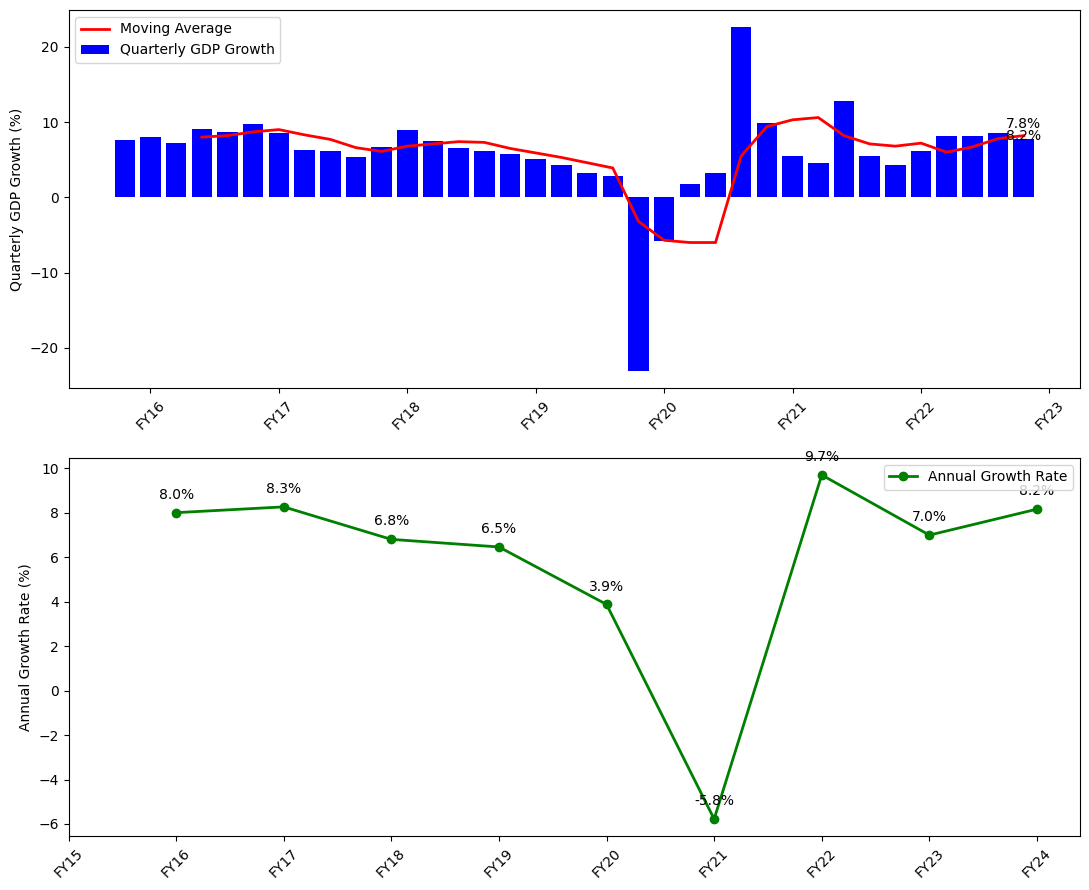

In [15]:
import matplotlib.pyplot as plt

# Extract the last growth value for both bar and line plots
last_quarter_growth = QGDPplotdatachart['QGDPgrowth'].iloc[-1]
last_ma_growth = QGDPplotdatachart['QGDPgrowth_MA'].iloc[-1]

# Create figure and axes for the bar chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 9))

# Plotting Quarterly GDP growth on the first axis as a bar chart with the last value
ax1.bar(QGDPplotdatachart.index, QGDPplotdatachart['QGDPgrowth'], color='blue', label='Quarterly GDP Growth')
ax1.bar(QGDPplotdatachart.index[-1], last_quarter_growth, color='blue')

# Adding label for the last quarterly growth value on the bar chart
ax1.text(QGDPplotdatachart.index[-1], last_quarter_growth + 1, f'{last_quarter_growth:.1f}%', ha='center', va='bottom')

# Plotting Moving Average on the first axis as a line chart with the last value
ax1.plot(QGDPplotdatachart.index, QGDPplotdatachart['QGDPgrowth_MA'], color='Red', label='Moving Average', linestyle='-', linewidth=2)
ax1.plot(QGDPplotdatachart.index[-1], last_ma_growth, markersize=8, color='green')

# Adding label for the last moving average growth value on the line chart
ax1.text(QGDPplotdatachart.index[-1], last_ma_growth - 1, f'{last_ma_growth:.1f}%', ha='center', va='bottom')

# Setting labels and title for the first axis
ax1.set_ylabel('Quarterly GDP Growth (%)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Set x-axis labels to fiscal years
ax1.set_xticklabels(QGDPplotdatachart['yearlabel'].unique())

# Plotting Annual Growth Rate on the second axis as a line chart
annual_growth = QGDPplotdatachart.groupby('yearlabel')['Annual_growth_rate'].mean()
ax2.plot(annual_growth.index, annual_growth.values, color='green', label='Annual Growth Rate', linestyle='-', linewidth=2, marker='o')

# Setting labels for the second axis
ax2.set_ylabel('Annual Growth Rate (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='upper right')

# Set major tick labels for the x-axis on the second subplot
ax2.set_xticks(annual_growth.index)

# Add labels to the points on the line graph
for x, y in zip(annual_growth.index, annual_growth.values):
    ax2.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plots
plt.tight_layout()
plt.show()


In [16]:
pip install chromium

Looking in indexes: https://172.17.0.207/root/pypi/+simple/
Note: you may need to restart the kernel to use updated packages.
